In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import unique, where
from collections import Counter
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import torch

import sys
sys.path.append("..")
from util.vis import t_sne, pca
from util.style_model import StyleModel
from util.clustering_eval import clustering_summary, print_clustering_classes, clustering_spacy_evaluation

In [2]:
test_data = pd.read_pickle('../data/04-1c_Authors_Test_Set.pkl')

# Style Embeddings from Style Model

In [3]:
model = StyleModel()
model.load_state_dict(torch.load('../model/Authors_StyleModel.pt'))

<All keys matched successfully>

In [4]:
messages = test_data["message"].tolist()

vectors = []

for message in tqdm(messages):
    vectors.append(model(message).squeeze().detach().numpy())

vectors = np.array(vectors)

100%|██████████| 14536/14536 [03:42<00:00, 65.47it/s]


## Centroids

In [5]:
authors_centroids = {}

for group in test_data.groupby('author_email'):
    author_embeddings = np.array(vectors[group[1].index])
    authors_centroids[group[0]] = np.mean(author_embeddings, axis = 0)

In [6]:
centroids_array = [value for value in authors_centroids.values()]

distances = pd.DataFrame(euclidean_distances(centroids_array, centroids_array))

for i in range(len(distances)):
    for j in range(i + 1):
        distances[j][i] = 0

distances.style.background_gradient(cmap='coolwarm').set_precision(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000,0.578,0.530,0.477,0.570,0.473,0.579,0.535,0.531,0.521,0.555,0.505,0.386,0.538,0.576
1,0.000,0.000,0.289,0.348,0.339,0.332,0.252,0.345,0.438,0.367,0.470,0.394,0.342,0.299,0.227
2,0.000,0.000,0.000,0.236,0.305,0.271,0.276,0.323,0.260,0.254,0.326,0.308,0.218,0.221,0.245
3,0.000,0.000,0.000,0.000,0.351,0.236,0.333,0.311,0.326,0.313,0.383,0.307,0.233,0.310,0.317
4,0.000,0.000,0.000,0.000,0.000,0.283,0.349,0.260,0.359,0.240,0.306,0.299,0.330,0.280,0.220
5,0.000,0.000,0.000,0.000,0.000,0.000,0.338,0.185,0.312,0.223,0.336,0.212,0.239,0.273,0.271
6,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.350,0.413,0.363,0.459,0.367,0.336,0.225,0.205
7,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.375,0.251,0.366,0.221,0.320,0.307,0.249
8,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.226,0.258,0.307,0.249,0.274,0.360
9,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.217,0.240,0.254,0.223,0.261


## PCA & t-SNE Visualizations

First, the generated vectors are reduced to two and three dimensions with PCA and t-SNE and visualized. Each of the seven authors gets a different color.

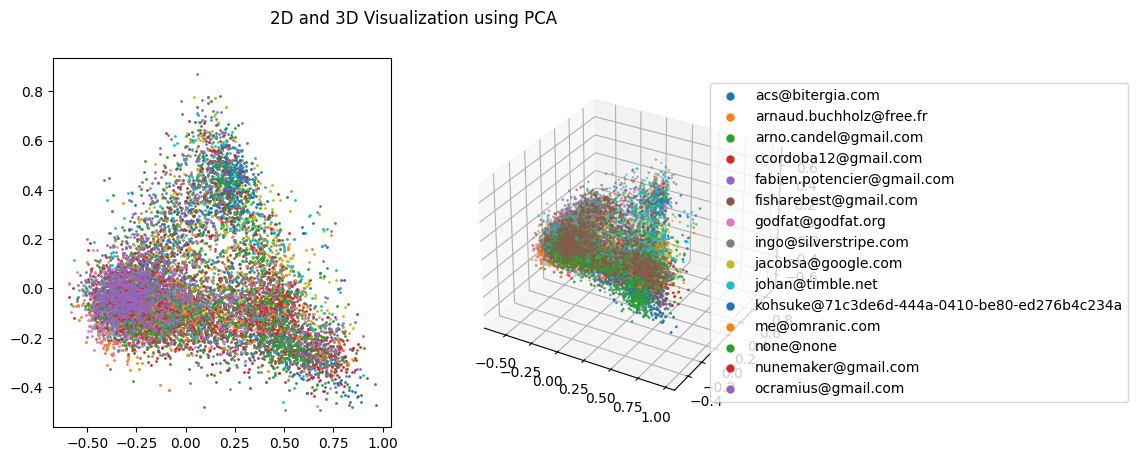

In [7]:
pca_2_prediction, pca_3_prediction = pca(vectors, test_data)

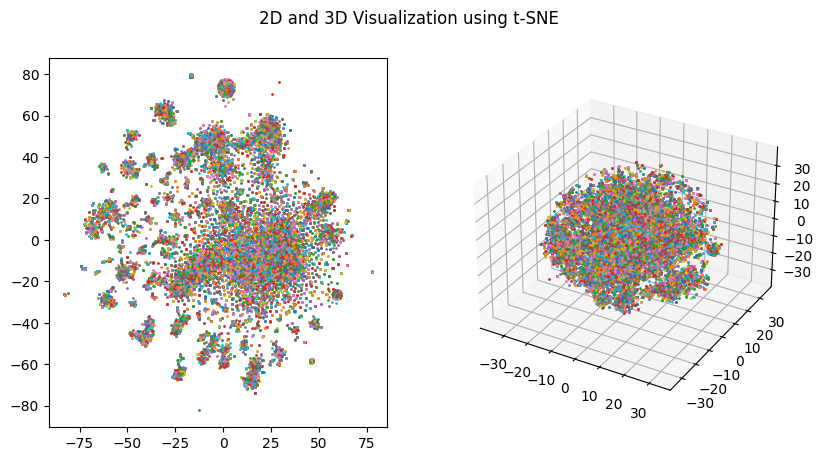

In [8]:
t_sne_2_prediction, t_sne_3_prediction = t_sne(vectors, test_data, legend = False)

## DBSCAN

DBSCAN: Density-based, no number of clusters needed, ability to provide min_samples to make one cluster

Number of Clusters: 8
10 Most common:
[(0, 12579), (-1, 1829), (1, 41), (3, 24), (2, 22), (5, 18), (6, 14), (4, 9)]


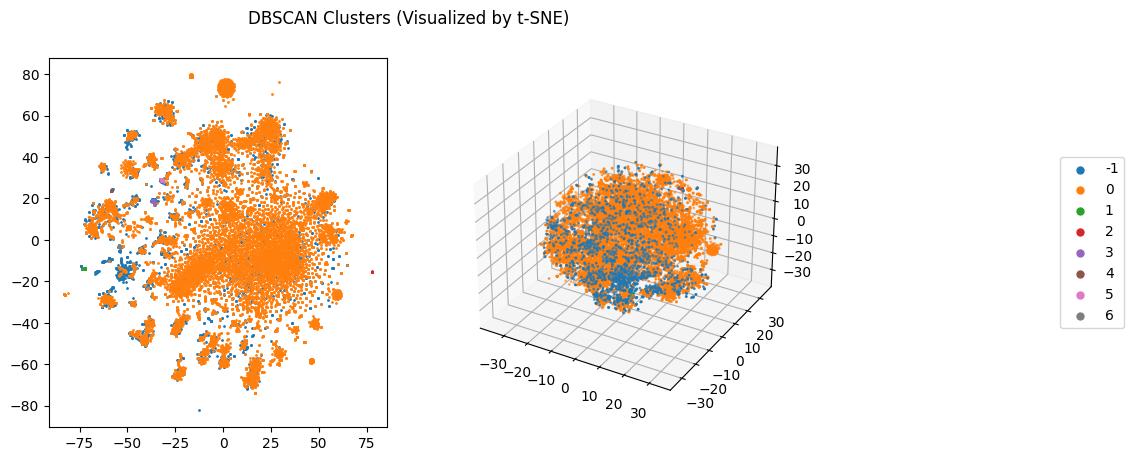

In [9]:
dbscan_model = DBSCAN(eps=0.7, min_samples=10)
dbscan_prediction = dbscan_model.fit_predict(vectors)

dbscan_clusters = unique(dbscan_prediction)

print(f"Number of Clusters: {len(dbscan_clusters)}")
print("10 Most common:")
print(Counter(dbscan_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for dbscan_cluster in dbscan_clusters:
    index = where(dbscan_prediction == dbscan_cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=dbscan_cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=dbscan_cluster)

fig.suptitle("DBSCAN Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [10]:
dbscan_summary = clustering_summary(dbscan_prediction, test_data)
dbscan_summary

There are 15 different authors.
There are 279 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,1829.0,15.0,113.0,"('none@none', 220)",144.0,2.0,"('fisharebest_webtrees', 203)"
1,12579.0,15.0,712.0,"('ccordoba12@gmail.com', 1806)",265.0,5.0,"('spyder-ide_spyder', 1632)"
2,41.0,2.0,20.5,"('acs@bitergia.com', 39)",9.0,2.0,"('chaoss_grimoirelab-perceval', 10)"
3,22.0,1.0,22.0,"('arnaud.buchholz@free.fr', 22)",1.0,22.0,"('ArnaudBuchholz_gpf-js', 22)"
4,24.0,4.0,2.5,"('nunemaker@gmail.com', 18)",10.0,1.0,"('jnunemaker_flipper', 7)"
5,9.0,1.0,9.0,('kohsuke@71c3de6d-444a-0410-be80-ed276b4c234a...,1.0,9.0,"('jenkinsci_jenkins', 9)"
6,18.0,3.0,3.0,"('none@none', 14)",5.0,3.0,"('wmdietl_jsr308-langtools', 10)"
7,14.0,6.0,1.0,"('nunemaker@gmail.com', 8)",7.0,1.0,"('jnunemaker_flipper', 7)"


In [11]:
dbscan_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,8.000000,8.000000,8.000000,8.000000,8.000000
mean,1817.000000,5.875000,110.375000,55.250000,5.625000
std,4394.280568,5.866065,245.895848,97.685721,7.130167
min,9.000000,1.000000,1.000000,1.000000,1.000000
25%,17.000000,1.750000,2.875000,4.000000,1.750000
50%,23.000000,3.500000,14.750000,8.000000,2.500000
75%,488.000000,8.250000,44.750000,43.500000,6.000000
max,12579.000000,15.000000,712.000000,265.000000,22.000000


In [12]:
clustering_spacy_evaluation(dbscan_prediction, test_data)

,0,1,2,3,4,5,6,7
length_mean,76.904866,73.991255,27.951220,30.818182,46.333333,117.000000,93.833333,61.000000
length_std,55.826684,55.366549,1.125128,8.962733,16.747305,26.865922,42.630519,23.877664
n_uppercase_mean,4.264079,3.926226,1.975610,2.000000,1.541667,16.555556,5.000000,1.500000
n_uppercase_std,4.497825,4.316403,0.154257,0.000000,0.865022,4.245550,2.886751,0.906327
polarity_mean,0.012742,0.011419,0.000000,0.000000,0.034328,-0.002820,-0.013889,0.029978
polarity_std,0.185626,0.168601,0.000000,0.000000,0.164788,0.131257,0.117622,0.092437
subjectivity_mean,0.211185,0.190537,0.000000,0.000000,0.193716,0.182576,0.177469,0.170265
subjectivity_std,0.278345,0.273161,0.000000,0.000000,0.250908,0.104522,0.284074,0.303444


In [13]:
print_clustering_classes(dbscan_prediction, test_data)


________________ Class 0 ________________

___
1) 
Removed not used code (old use of pullrequests API).
___
2) 
[track_items] Check that upstream contributors file exists. If not, log it and return and
empty list of items.
___
3) 
[gerrit elk] Fixed dates in review before using them.
___
4) 
[Bugzilla SH Identities] Add email if we have this data.
___
5) 
Changed default self.max_items_bulk to <I> so it works in remote elastic cases.
___
6) 
[confluence][enrich] Support that username or displayName are not included in user data
___
7) 
[enrich][jenkins] Remove wrong log with the lines in the rename file
___
8) 
[mordred] Remove the general load of identities used during the initial step.
In mordred since <I> there is not an initial step anymore.
Identities are loaded before enrichment as usual.
___
9) 
[enrich][confluence] Add the new field content_url to the enrich index.

With this field the confluence page is known and it can be use for agg and filtering.
___
10) 
[panels] Add hype

## K-Means

Centroid-Based, fixed number of Clusters

Goal: Find seven clusters for seven authors

In [62]:
silhouette_scores = []
k_range = range(3, 15, 1)

for k in k_range:
    kmeans = KMeans(k)
    kmeans_prediction = kmeans.fit_predict(vectors)
    silhouette_scores.append(silhouette_score(vectors, kmeans_prediction))

k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Number of clusters with max silhouette score: {k}")

Number of clusters with max silhouette score: 3


Number of Clusters: 3
10 Most common:
[(0, 8653), (1, 3495), (2, 2388)]


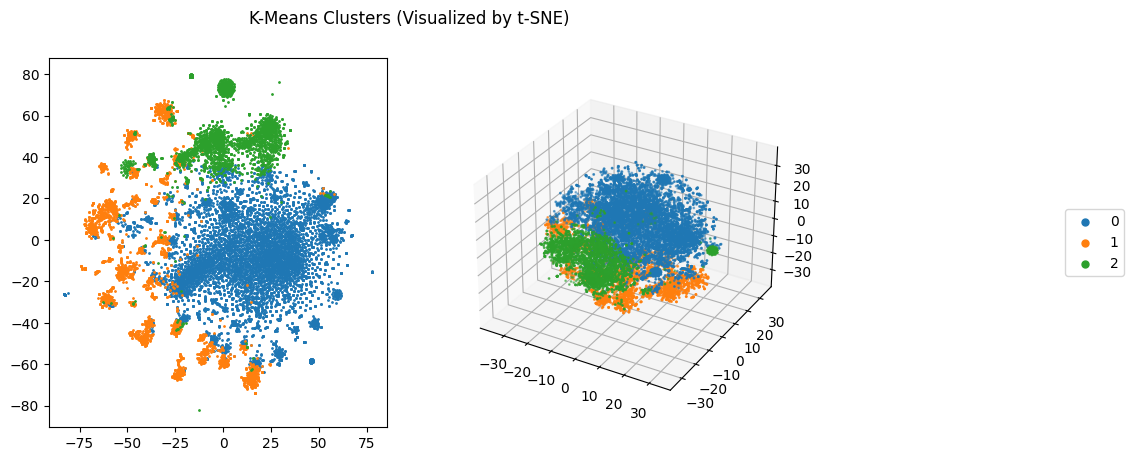

In [64]:
kmeans = KMeans(k)
kmeans_prediction = kmeans.fit_predict(vectors)

kmeans_clusters = unique(kmeans_prediction)

print(f"Number of Clusters: {len(kmeans_clusters)}")
print("10 Most common:")
print(Counter(kmeans_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for cluster in kmeans_clusters:
    index = where(kmeans_prediction == cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=cluster)

fig.suptitle("K-Means Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [41]:
kmeans_summary = clustering_summary(kmeans_prediction, test_data)
kmeans_summary

There are 15 different authors.
There are 279 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,508.0,11.0,3.0,"('acs@bitergia.com', 304)",18.0,2.5,"('chaoss_grimoirelab-elk', 245)"
1,1985.0,15.0,98.0,"('ccordoba12@gmail.com', 480)",145.0,3.0,"('spyder-ide_spyder', 439)"
2,186.0,10.0,2.5,"('fisharebest@gmail.com', 121)",15.0,2.0,"('fisharebest_webtrees', 121)"
3,1978.0,15.0,97.0,"('fabien.potencier@gmail.com', 555)",156.0,2.0,"('symfony_symfony', 446)"
4,342.0,14.0,8.5,"('nunemaker@gmail.com', 94)",70.0,2.0,"('jnunemaker_flipper', 45)"
5,862.0,15.0,21.0,"('ingo@silverstripe.com', 260)",114.0,2.0,"('fisharebest_webtrees', 166)"
6,286.0,14.0,5.0,"('me@omranic.com', 99)",56.0,2.5,"('joomlatools_joomlatools-framework', 45)"
7,1075.0,15.0,47.0,"('fabien.potencier@gmail.com', 249)",92.0,2.0,"('symfony_symfony', 241)"
8,490.0,15.0,14.0,"('fabien.potencier@gmail.com', 94)",90.0,2.0,"('fisharebest_webtrees', 65)"
9,858.0,15.0,61.0,"('jacobsa@google.com', 131)",93.0,2.0,"('jenkinsci_jenkins', 93)"


In [17]:
kmeans_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,15.000000,15.000000,15.000000,15.000000,15.000000
mean,969.066667,12.800000,52.666667,78.266667,11.200000
std,1154.275126,3.589668,63.762861,57.512069,35.223673
min,149.000000,2.000000,3.000000,2.000000,1.000000
25%,282.500000,12.500000,4.250000,33.000000,2.000000
50%,509.000000,14.000000,23.000000,73.000000,2.000000
75%,885.500000,15.000000,76.000000,114.000000,3.000000
max,4307.000000,15.000000,214.000000,175.000000,138.500000


In [18]:
clustering_spacy_evaluation(kmeans_prediction, test_data)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
length_mean,69.988623,72.251249,89.641686,85.854691,78.927803,96.532887,32.866667,49.756944,96.449902,78.080537,72.144487,69.522440,29.794224,68.527624,63.480969
length_std,52.003091,54.619778,56.205965,60.219721,56.772529,73.991708,20.133353,36.344847,62.268321,51.833175,45.934012,47.846956,2.118571,43.130030,44.562262
n_uppercase_mean,3.602043,3.917916,5.206089,4.556064,4.226310,5.983278,1.854545,2.600694,3.565815,4.040268,4.954373,4.069045,2.534296,2.110497,3.553633
n_uppercase_std,3.731526,4.439583,4.122783,4.770206,4.689840,6.251221,2.402662,2.475631,4.256290,2.951235,3.706665,4.857682,1.325839,2.857374,3.545430
polarity_mean,0.013546,0.009633,0.000242,0.028947,0.013569,0.015645,0.005515,0.006290,-0.007027,0.015197,-0.003533,-0.002134,0.000000,0.002485,0.020788
polarity_std,0.174812,0.162964,0.148864,0.190088,0.165651,0.182054,0.082530,0.144133,0.192769,0.170899,0.179197,0.171944,0.000000,0.196404,0.165547
subjectivity_mean,0.189704,0.194908,0.184084,0.226166,0.196901,0.247340,0.063883,0.127902,0.228055,0.252284,0.192844,0.186295,0.000000,0.235462,0.162016
subjectivity_std,0.276143,0.261317,0.264878,0.281530,0.266258,0.309919,0.152470,0.269325,0.287220,0.285694,0.260574,0.265706,0.000000,0.317744,0.260045


In [19]:
print_clustering_classes(kmeans_prediction, test_data)


________________ Class 0 ________________

___
1) 
[release] Update version number to <I>
___
2) 
[logs] Remove logs related to getting last update.
___
3) 
[release] Update version number to <I>
___
4) 
[Enrich Gerrit] Add organization and bot from Sorting Hat.
___
5) 
[task_collection] Add a specific tag param to arthur collected raw items
___
6) 
[release] Update version number to <I>
___
7) 
[release] Update version number to <I>
___
8) 
[release] Update version number to <I>
___
9) 
[release] Update version number to <I>
___
10) 
[utils] If Kibiter version can not be found just return None
_________________

Number of messages in this class: 4307
Most common author:
('ccordoba12@gmail.com', 720)
Most common project:
('spyder-ide_spyder', 642)



________________ Class 1 ________________

___
1) 
Removed not used code (old use of pullrequests API).
___
2) 
Update version number to <I>
___
3) 
[Bugzilla SH Identities] Add email if we have this data.
___
4) 
[gh2arthur] Use "scm" an